# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

In [70]:
# local에서 실행하므로 필요 x

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [71]:
import os
import time
import random
from sklearn.model_selection import train_test_split # 수정함

import matplotlib.pyplot as plt
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [72]:
# 시드 고정
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [73]:
# 데이터셋 클래스를 정의
class ImageDataset(Dataset):
    def __init__(self, df, path, transform=None): # 수정함
        self.df = df.values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [74]:
# one epoch 학습을 위한 함수
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "loss": train_loss, # 수정함
        "acc": train_acc,
        "f1": train_f1,
    }

    return ret

In [75]:
# EarlyStopping을 위한 클래스를 정의 # 수정함
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(score, model)
            self.counter = 0

    def save_checkpoint(self, score, model):
        if self.verbose:
            print(f'Score increased ({self.best_score:.6f} --> {score:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [76]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '.\data\train'

# 베이스라인 잡기 위해서 resnet34 로 고정해서 전처리 찾아보기
# model config
model_name = 'resnet34'
#model_name = 'resnet50'
#model_name = 'resnet101'

#from efficientnet_pytorch import EfficientNet
#model_name = 'tf_efficientnet_b0'

#model_name = 'densenet201'  # 또는 'densenet169', 'densenet201', 'densenet161'

# training config
img_size = 32
LR = 1e-3
EPOCHS = 30
BATCH_SIZE = 32
num_workers = 0

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [77]:
# augmentation을 위한 transform 코드 # 수정함
trn_transform = A.Compose([
    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),
    # 이미지 회전 효과 적용 (360도 무작위 회전)
    A.Rotate(limit=180, p=0.5),  # limit 값을 180으로 설정
    # 이미지 좌우 반전 효과 적용
    A.HorizontalFlip(p=0.5),  #아차! 하고 추가함
    # 이미지 밝기/대비 조정 효과 적용
    A.RandomBrightnessContrast(p=0.3),
    # test 데이터 이미지에 흐릿한 이미지가 있었으므로 블러 추가
    A.Blur(blur_limit=3, p=0.1),
    # 채도 변화
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.2),
    # 이미지 선명도 조절
    A.RandomGamma(gamma_limit=(80, 120), p=0.2),
    # images normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [78]:
# Data split # 수정함
df = pd.read_csv("./data/train.csv")
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df.iloc[:, -1])

c:\Users\robot\data_study\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\robot\data_study\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [79]:
# Dataset 정의
trn_dataset = ImageDataset(
    train_df, # 수정함
    "./data/train/",
    transform=trn_transform
)
val_dataset = ImageDataset( # 수정함
    valid_df,
    "./data/train/",
    transform=trn_transform
)
tst_dataset = ImageDataset(
    pd.read_csv("./data/sample_submission.csv"), # 수정함
    "./data/test/",
    transform=tst_transform
)
print(len(trn_dataset), len(val_dataset), len(tst_dataset)) # 수정함


1256 314 3140


In [80]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
val_loader = DataLoader( # 수정함
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [81]:
# load model
model = timm.create_model(
    model_name,
    #'tf_efficientnet_b7',
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [82]:
# EarlyStopping 객체를 생성 # 수정함
early_stopping = EarlyStopping(patience=10, verbose=True)

In [83]:
# 학습 과정에서의 손실, 정확도, f1 score 값을 저장할 리스트를 생성. for 시각화
train_losses = []
train_accs = []
train_f1s = []

val_losses = []
val_accs = []
val_f1s = []

In [84]:
optimizer = Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

In [85]:
for epoch in range(EPOCHS):
    ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
    ret['epoch'] = epoch

    # 손실, 정확도, f1 score 값을 리스트에 추가
    train_losses.append(ret['loss'])
    train_accs.append(ret['acc'])
    train_f1s.append(ret['f1'])

    log = ""
    for k, v in ret.items():
      log += f"Train {k}: {v:.4f}\n"
    print(log)

    # validation
    val_ret = train_one_epoch(val_loader, model, optimizer, loss_fn, device=device)
    val_log = ""
    for k, v in val_ret.items():
      val_log += f"Val {k}: {v:.4f}\n"
      
    # 손실, 정확도, f1 score 값을 리스트에 추가
    val_losses.append(val_ret['loss'])
    val_accs.append(val_ret['acc'])
    val_f1s.append(val_ret['f1'])

    print(val_log)

    # Early stopping check
    early_stopping(-val_ret['loss'], model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # 학습률 조정
    scheduler.step(val_ret['loss'])

Loss: 2.7489: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s]


Train loss: 2.1400
Train acc: 0.3376
Train f1: 0.3040
Train epoch: 0.0000



Loss: 1.6213: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Val loss: 1.6691
Val acc: 0.4618
Val f1: 0.4264

Score increased (-1.669067 --> -1.669067). Saving model ...


Loss: 3.4413: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s]


Train loss: 1.6761
Train acc: 0.4729
Train f1: 0.4347
Train epoch: 1.0000



Loss: 1.3396: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Val loss: 1.4463
Val acc: 0.5127
Val f1: 0.4839

Score increased (-1.446258 --> -1.446258). Saving model ...


Loss: 1.2238: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s]


Train loss: 1.4193
Train acc: 0.5199
Train f1: 0.4915
Train epoch: 2.0000



Loss: 1.3095: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Val loss: 1.4097
Val acc: 0.4904
Val f1: 0.4531

Score increased (-1.409658 --> -1.409658). Saving model ...


Loss: 1.5654: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]


Train loss: 1.2726
Train acc: 0.5725
Train f1: 0.5431
Train epoch: 3.0000



Loss: 2.0093: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Val loss: 1.2469
Val acc: 0.5955
Val f1: 0.5559

Score increased (-1.246937 --> -1.246937). Saving model ...


Loss: 2.1571: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]


Train loss: 1.1553
Train acc: 0.6027
Train f1: 0.5721
Train epoch: 4.0000



Loss: 1.1033: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Val loss: 1.0541
Val acc: 0.6306
Val f1: 0.5933

Score increased (-1.054104 --> -1.054104). Saving model ...


Loss: 2.5744: 100%|██████████| 40/40 [00:17<00:00,  2.24it/s]


Train loss: 1.2270
Train acc: 0.6210
Train f1: 0.5944
Train epoch: 5.0000



Loss: 1.3580: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Val loss: 1.1373
Val acc: 0.6433
Val f1: 0.6061

EarlyStopping counter: 1 out of 10


Loss: 1.5480: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]


Train loss: 1.0807
Train acc: 0.6465
Train f1: 0.6065
Train epoch: 6.0000



Loss: 1.5603: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Val loss: 1.0590
Val acc: 0.6369
Val f1: 0.5987

EarlyStopping counter: 2 out of 10


Loss: 1.0474: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]


Train loss: 1.0095
Train acc: 0.6489
Train f1: 0.6177
Train epoch: 7.0000



Loss: 0.6442: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Val loss: 0.8208
Val acc: 0.7197
Val f1: 0.6809

Score increased (-0.820782 --> -0.820782). Saving model ...


Loss: 3.0398: 100%|██████████| 40/40 [00:18<00:00,  2.12it/s]


Train loss: 1.0037
Train acc: 0.6704
Train f1: 0.6394
Train epoch: 8.0000



Loss: 1.1498: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Val loss: 0.9602
Val acc: 0.6433
Val f1: 0.5949

EarlyStopping counter: 1 out of 10


Loss: 0.6510: 100%|██████████| 40/40 [00:18<00:00,  2.14it/s]


Train loss: 0.9967
Train acc: 0.6640
Train f1: 0.6274
Train epoch: 9.0000



Loss: 0.9625: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Val loss: 0.8752
Val acc: 0.6943
Val f1: 0.6705

EarlyStopping counter: 2 out of 10


Loss: 0.5724: 100%|██████████| 40/40 [00:18<00:00,  2.13it/s]


Train loss: 0.9202
Train acc: 0.6775
Train f1: 0.6425
Train epoch: 10.0000



Loss: 0.9566: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val loss: 0.9144
Val acc: 0.6656
Val f1: 0.6337

EarlyStopping counter: 3 out of 10


Loss: 0.3966: 100%|██████████| 40/40 [00:18<00:00,  2.12it/s]


Train loss: 0.8827
Train acc: 0.6855
Train f1: 0.6533
Train epoch: 11.0000



Loss: 1.1392: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val loss: 0.7927
Val acc: 0.7166
Val f1: 0.6806

Score increased (-0.792664 --> -0.792664). Saving model ...


Loss: 1.3170: 100%|██████████| 40/40 [00:18<00:00,  2.12it/s]


Train loss: 0.7982
Train acc: 0.7182
Train f1: 0.6935
Train epoch: 12.0000



Loss: 0.6839: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Val loss: 0.6866
Val acc: 0.7516
Val f1: 0.7153

Score increased (-0.686553 --> -0.686553). Saving model ...


Loss: 1.2357: 100%|██████████| 40/40 [00:18<00:00,  2.13it/s]


Train loss: 0.7857
Train acc: 0.7317
Train f1: 0.6991
Train epoch: 13.0000



Loss: 0.8677: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Val loss: 0.7447
Val acc: 0.7229
Val f1: 0.6949

EarlyStopping counter: 1 out of 10


Loss: 1.5985: 100%|██████████| 40/40 [00:19<00:00,  2.08it/s]


Train loss: 0.7910
Train acc: 0.7197
Train f1: 0.6886
Train epoch: 14.0000



Loss: 0.8812: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Val loss: 0.6673
Val acc: 0.7484
Val f1: 0.7265

Score increased (-0.667266 --> -0.667266). Saving model ...


Loss: 1.1364: 100%|██████████| 40/40 [00:18<00:00,  2.11it/s]


Train loss: 0.8270
Train acc: 0.7110
Train f1: 0.6785
Train epoch: 15.0000



Loss: 0.9104: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val loss: 0.7196
Val acc: 0.7611
Val f1: 0.7260

EarlyStopping counter: 1 out of 10


Loss: 2.5204: 100%|██████████| 40/40 [00:18<00:00,  2.14it/s]


Train loss: 0.8197
Train acc: 0.7285
Train f1: 0.6973
Train epoch: 16.0000



Loss: 0.6787: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val loss: 0.6050
Val acc: 0.7803
Val f1: 0.7553

Score increased (-0.604964 --> -0.604964). Saving model ...


Loss: 1.2749: 100%|██████████| 40/40 [00:18<00:00,  2.13it/s]


Train loss: 0.7446
Train acc: 0.7365
Train f1: 0.7067
Train epoch: 17.0000



Loss: 0.7688: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Val loss: 0.7356
Val acc: 0.7675
Val f1: 0.7426

EarlyStopping counter: 1 out of 10


Loss: 1.1236: 100%|██████████| 40/40 [00:18<00:00,  2.13it/s]


Train loss: 0.7825
Train acc: 0.7253
Train f1: 0.6924
Train epoch: 18.0000



Loss: 0.9042: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val loss: 0.6800
Val acc: 0.7516
Val f1: 0.7203

EarlyStopping counter: 2 out of 10


Loss: 0.6781: 100%|██████████| 40/40 [00:18<00:00,  2.15it/s]


Train loss: 0.7295
Train acc: 0.7404
Train f1: 0.7127
Train epoch: 19.0000



Loss: 0.5849: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val loss: 0.6345
Val acc: 0.7580
Val f1: 0.7186

EarlyStopping counter: 3 out of 10


Loss: 0.3837: 100%|██████████| 40/40 [00:18<00:00,  2.14it/s]


Train loss: 0.7112
Train acc: 0.7412
Train f1: 0.7162
Train epoch: 20.0000



Loss: 0.6435: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Val loss: 0.5460
Val acc: 0.8121
Val f1: 0.7882

Score increased (-0.546046 --> -0.546046). Saving model ...


Loss: 0.6858: 100%|██████████| 40/40 [00:18<00:00,  2.13it/s]


Train loss: 0.7122
Train acc: 0.7460
Train f1: 0.7172
Train epoch: 21.0000



Loss: 0.5194: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Val loss: 0.5691
Val acc: 0.7962
Val f1: 0.7671

EarlyStopping counter: 1 out of 10


Loss: 1.2015: 100%|██████████| 40/40 [00:18<00:00,  2.13it/s]


Train loss: 0.6863
Train acc: 0.7444
Train f1: 0.7124
Train epoch: 22.0000



Loss: 0.9200: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Val loss: 0.6837
Val acc: 0.7229
Val f1: 0.6997

EarlyStopping counter: 2 out of 10


Loss: 2.5527: 100%|██████████| 40/40 [00:19<00:00,  2.10it/s]


Train loss: 0.7757
Train acc: 0.7604
Train f1: 0.7345
Train epoch: 23.0000



Loss: 0.5866: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val loss: 0.5952
Val acc: 0.7739
Val f1: 0.7485

EarlyStopping counter: 3 out of 10


Loss: 4.5295: 100%|██████████| 40/40 [00:18<00:00,  2.14it/s]


Train loss: 0.7221
Train acc: 0.7731
Train f1: 0.7447
Train epoch: 24.0000



Loss: 0.8261: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Val loss: 0.6558
Val acc: 0.7707
Val f1: 0.7447

EarlyStopping counter: 4 out of 10


Loss: 0.4773: 100%|██████████| 40/40 [00:19<00:00,  2.08it/s]


Train loss: 0.7137
Train acc: 0.7588
Train f1: 0.7323
Train epoch: 25.0000



Loss: 0.9812: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val loss: 0.6018
Val acc: 0.8057
Val f1: 0.7667

EarlyStopping counter: 5 out of 10


Loss: 1.5939: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


Train loss: 0.7031
Train acc: 0.7667
Train f1: 0.7356
Train epoch: 26.0000



Loss: 0.4989: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val loss: 0.5466
Val acc: 0.7994
Val f1: 0.7693

EarlyStopping counter: 6 out of 10


Loss: 1.2572: 100%|██████████| 40/40 [00:18<00:00,  2.15it/s]


Train loss: 0.6131
Train acc: 0.7874
Train f1: 0.7628
Train epoch: 27.0000



Loss: 0.5267: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val loss: 0.4432
Val acc: 0.8312
Val f1: 0.8144

Score increased (-0.443165 --> -0.443165). Saving model ...


Loss: 1.0764: 100%|██████████| 40/40 [00:18<00:00,  2.15it/s]


Train loss: 0.5296
Train acc: 0.8081
Train f1: 0.7892
Train epoch: 28.0000



Loss: 0.5339: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Val loss: 0.3803
Val acc: 0.8631
Val f1: 0.8383

Score increased (-0.380312 --> -0.380312). Saving model ...


Loss: 0.3285: 100%|██████████| 40/40 [00:18<00:00,  2.16it/s]


Train loss: 0.4877
Train acc: 0.8240
Train f1: 0.7984
Train epoch: 29.0000



Loss: 0.5026: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]

Val loss: 0.3939
Val acc: 0.8471
Val f1: 0.8166

EarlyStopping counter: 1 out of 10


In [86]:
model.load_state_dict(torch.load('checkpoint.pt')) # 수정함

<All keys matched successfully>

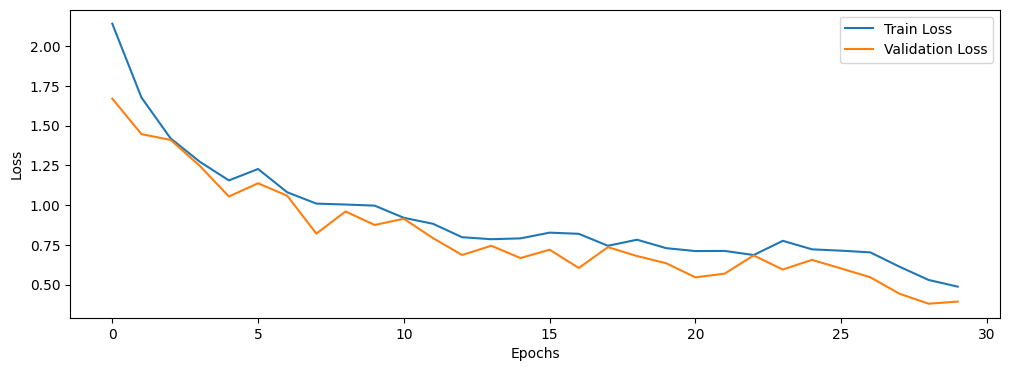

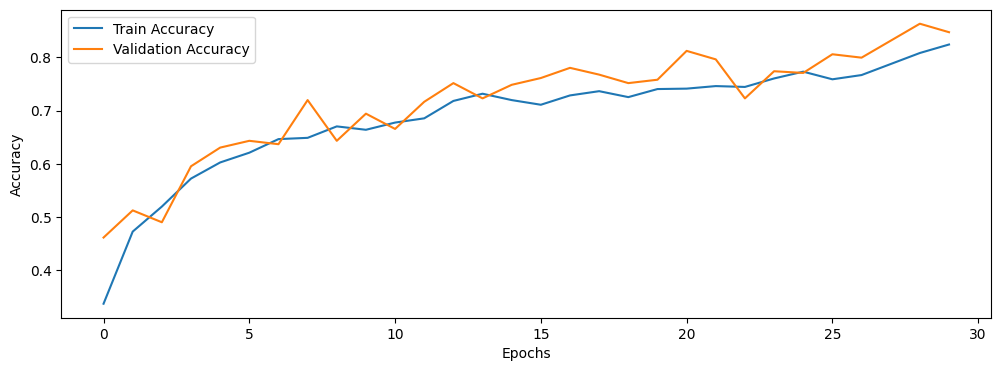

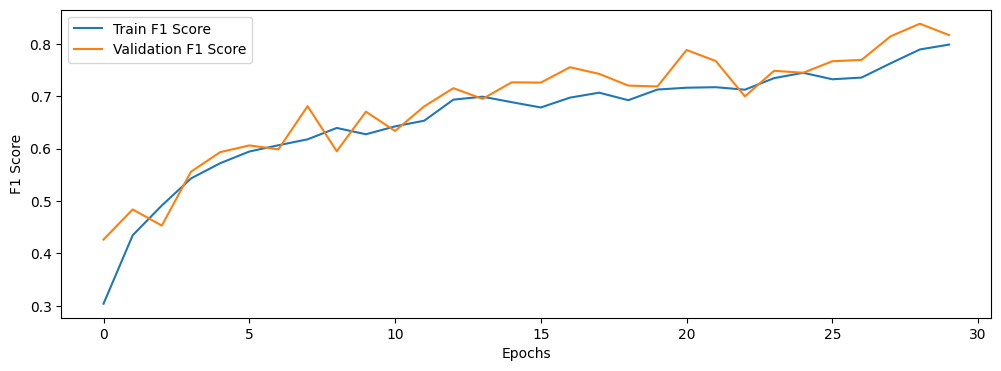

In [87]:
# 손실 그래프
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 그래프
plt.figure(figsize=(12, 4))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# f1 score 그래프
plt.figure(figsize=(12, 4))
plt.plot(train_f1s, label='Train F1 Score')
plt.plot(val_f1s, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

#### 로컬 평가 
- train_loss은 학습 데이터에 대한 모델의 평균 손실값을 의미합니다. 손실값은 모델의 예측이 실제 값과 얼마나 차이나는지를 나타내는 지표로, 이 값이 작을수록 모델의 성능이 좋다고 할 수 있습니다.
- train_acc은 학습 데이터에 대한 모델의 정확도를 의미합니다. 정확도는 모델이 올바르게 분류한 데이터의 비율을 나타내는 지표로, 이 값이 클수록 모델의 성능이 좋다고 할 수 있습니다.
- train_f1은 학습 데이터에 대한 모델의 F1 점수를 의미합니다. F1 점수는 정밀도(precision)와 재현율(recall)의 조화 평균을 나타내는 지표로, 이 값이 클수록 모델의 성능이 좋다고 할 수 있습니다.
- 결론 : F1 점수 높을수록 좋음.  

F1 점수는 정밀도(Precision)와 재현율(Recall)의 조화 평균을 나타내는 지표입니다. 정밀도는 모델이 True라고 분류한 것 중에서 실제로 True인 것의 비율을, 재현율은 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율을 나타냅니다.

F1 점수는 이 두 가지 지표를 모두 고려하므로, 모델이 양성 클래스를 얼마나 잘 분류하는지를 종합적으로 평가하는 데 유용합니다. 따라서 F1 점수가 높을수록 모델의 성능이 좋다고 할 수 있습니다.

특히 클래스 불균형 문제가 있는 경우에는 정확도(Accuracy)만으로는 모델의 성능을 제대로 평가할 수 없으므로, F1 점수와 같은 지표를 사용합니다. 이런 문제에서는 소수 클래스의 샘플을 잘 분류하는 것이 중요한데, F1 점수는 이를 잘 반영합니다.

그러나 F1 점수도 완벽한 지표는 아닙니다. 예를 들어, 모델이 모든 샘플을 양성 클래스로 분류하면 재현율은 1이지만, 정밀도는 매우 낮아집니다. 이런 경우에는 F1 점수가 과하게 높아질 수 있습니다. 따라서 F1 점수 외에도 다른 평가 지표를 함께 고려하는 것이 좋습니다.

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [88]:
preds_list = []

model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:15<00:00,  6.50it/s]


In [89]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [90]:
sample_submission_df = pd.read_csv("./data/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [91]:
pred_df.to_csv("pred.csv", index=False)

In [92]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,4
4,00901f504008d884.jpg,2
